In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [3]:
# setting the directory for dataset
train_dir = "static/archive/train"
val_dir = "static/archive/val"
test_dir = "static/archive/test"

In [4]:
# getting classnames
class_names = []
for dir_name in os.listdir(train_dir):
    class_names.append(dir_name)

In [5]:
# setting up filenames list
covid_img_paths = []
normal_img_paths = []
pneumonia_img_paths = []
tuberculosis_img_paths = []
def get_filenames(dir):
    """
    Gets filenames under the given directory
    """
    filenames = []
    for dir_name in os.listdir(dir):
        for file_name in os.listdir(dir + "/" + dir_name):
            filenames.append(dir + "/" + dir_name + "/" + file_name)
    return filenames
train_images = get_filenames(train_dir)
val_images = get_filenames(val_dir)
test_images = get_filenames(test_dir)


In [6]:
device = 'cpu'
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1) 

C:\Users\Sumedh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [7]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'

In [8]:
def preprocess_images(path, shuffle=False):
    """
    Preprocess all the images in the given directory
    """
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory=path, batch_size=32, image_size=(224, 224), label_mode="categorical", seed=42, shuffle=shuffle
    )
    return dataset

In [9]:
val_dataset = preprocess_images(val_dir, shuffle=True)

Found 38 files belonging to 4 classes.


In [10]:
test_dataset = preprocess_images(test_dir, shuffle=False) # shuffle-False for evaluation

Found 771 files belonging to 4 classes.


In [11]:
train_dataset = preprocess_images(train_dir, shuffle=True)

Found 6326 files belonging to 4 classes.


In [12]:
tf.random.set_seed(42)

# creating a neural network with dense layers
model_1 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1/255.),
    tf.keras.layers.Flatten(), # needs to be flattened
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(4, activation="softmax")
], name="model_1_Dense")

# compiling the model
model_1.compile(
    loss="categorical_crossentropy",
    optimizer="Adam",
    metrics=["accuracy"]
)

# fitting the model
model_1_history = model_1.fit(train_dataset, epochs=2, validation_data=val_dataset)

Epoch 1/2
145/198 [====================>.........] - ETA: 12s - loss: 2.1648 - accuracy: 0.6078

InvalidArgumentError: Graph execution error:

Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_1343]

In [ ]:
%%time
# making predictions
model_1_pred_probs = model_1.predict(test_dataset)
model_1_pred_probs[:5]

25/25 [==============================] - 4s 107ms/step
CPU times: total: 20.8 s
Wall time: 3.59 s


array([[1.9085985e-02, 3.1207651e-02, 9.4795305e-01, 1.7534164e-03],
       [8.4743756e-01, 8.5273953e-03, 1.4298521e-01, 1.0498428e-03],
       [6.9043612e-01, 2.2956288e-01, 3.9951812e-02, 4.0049233e-02],
       [4.1370773e-01, 4.6145314e-01, 2.5790342e-04, 1.2458120e-01],
       [2.4035533e-01, 1.0759473e-04, 9.7002042e-03, 7.4983686e-01]],
      dtype=float32)

In [ ]:
def custom_prediction(model, img_path, rescale=False, org_label=False):
    """
    Returns a plotted image with predicted class and its probability
    """

    # first we need to preprocess the image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, size=[224,224])
    if rescale:
        image = image / 255.
    # rescaling is not needed for EfficientNetV2B0 since it has a rescaling layer

    # making predictions
    pred_probs = model.predict(tf.expand_dims(image, axis=0)) # needs to be expanded due to batched train data
    preds = pred_probs.argmax(axis=1)

    color = "black"
    # if label is specified
    if org_label:
        if org_label == class_names[preds[0]]:
            color="green"
        else:
            color="red"

    # plotting the prediction with image
    plt.figure(figsize=(10,7))
    plt.imshow(plt.imread(img_path))
    plt.title(f"Prediction: {class_names[preds[0]].upper()}\nPrediction Probability: {np.max(pred_probs)*100:.2f}%", color=color)

    # if label is specified
    if org_label:
        plt.suptitle(f"Original: {org_label.upper()}", color="green")

    plt.xticks([])
    plt.yticks([]);

1/1 [==============================] - 0s 61ms/step


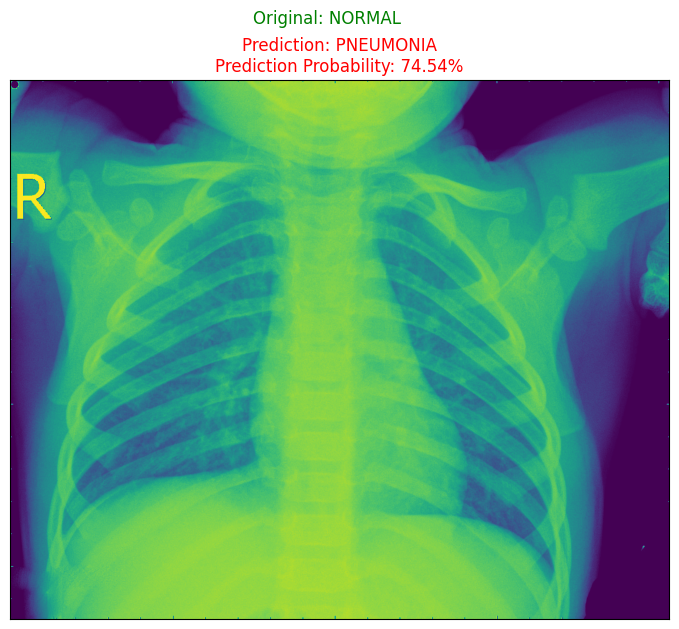

In [ ]:
custom_prediction(model=model_1, img_path="archive/val/NORMAL/NORMAL2-IM-1430-0001.jpeg", org_label="NORMAL")

In [ ]:
import pickle

In [ ]:
# Saving model to disk
pickle.dump(model_1_history, open('model.pkl','wb'))

# Loading model to compare the results
model = pickle.load(open('model.pkl','rb'))
print(model.predict([[2, 9, 6]]))

NameError: name 'model_1_history' is not defined